Importare

In [1]:
from SilentInfarctionSegmentationFLAIR import histograms
from SilentInfarctionSegmentationFLAIR import utils
from SilentInfarctionSegmentationFLAIR import segmentation
from SilentInfarctionSegmentationFLAIR import refinement
from SilentInfarctionSegmentationFLAIR import refinement_step
from SilentInfarctionSegmentationFLAIR import threshold
import importlib
importlib.reload(utils)
importlib.reload(segmentation)
importlib.reload(histograms)
importlib.reload(threshold)
importlib.reload(refinement)
importlib.reload(refinement_step)
from SilentInfarctionSegmentationFLAIR.histograms import *
from SilentInfarctionSegmentationFLAIR.segmentation import *
from SilentInfarctionSegmentationFLAIR.refinement import *
from SilentInfarctionSegmentationFLAIR.utils import *


Impostare

In [2]:
gm_labels = [3, 8, 10, 11, 12, 13, 17, 18, 26,
              42, 47, 49, 50, 51, 52, 53, 54, 62]
wm_labels = [2, 7, 41, 46]
# please refer to FsTutorial/AnatomicalROI/FreeSurferColorLUT from the FreeSurfer documentation
flair_file = "FLAIR.nii"
t1_file = "T1ontoFLAIR.nii"
segm_file = "aseg.auto_noCCseg.nii"
gm_pve_file = "pve_gm.nii"
wm_pve_file = "pve_wm.nii"
csf_pve_file = "pve_csf.nii"
gt_file = "GT.nii"
label_name_file = "data/FreeSurferColorLUT.txt"

Organizzare

In [3]:
import os
import pandas as pd

# organize all images in a df
paths_list = []
for root, _, files in os.walk("data"):
    for file in files:
        if file.endswith(".nii"):
            paths_list.append((root,file))
paths_df = pd.DataFrame()
for root, file in paths_list:
    paths_df.loc[root,file] = os.path.join(root,file)

# extract label names
labels_dict = label_names(label_name_file)


Vediamo gli istogrammi GM e istogrammi lesioni nella FLAIR.
  
Le lesioni risultano:  
    - molto iperintense rispetto a WM (bene)  
    - simili rispetto a GM (male)  

Loading image data/GE005M/FLAIR.nii...
Computing ground truth and segmentation masks...
Computing histogram...
Loading image data/GE0001/FLAIR.nii...
Computing ground truth and segmentation masks...
Computing histogram...
Loading image data/PD0006/FLAIR.nii...
Computing ground truth and segmentation masks...
Computing histogram...
Loading image data/PD0001/FLAIR.nii...
Computing ground truth and segmentation masks...
Computing histogram...


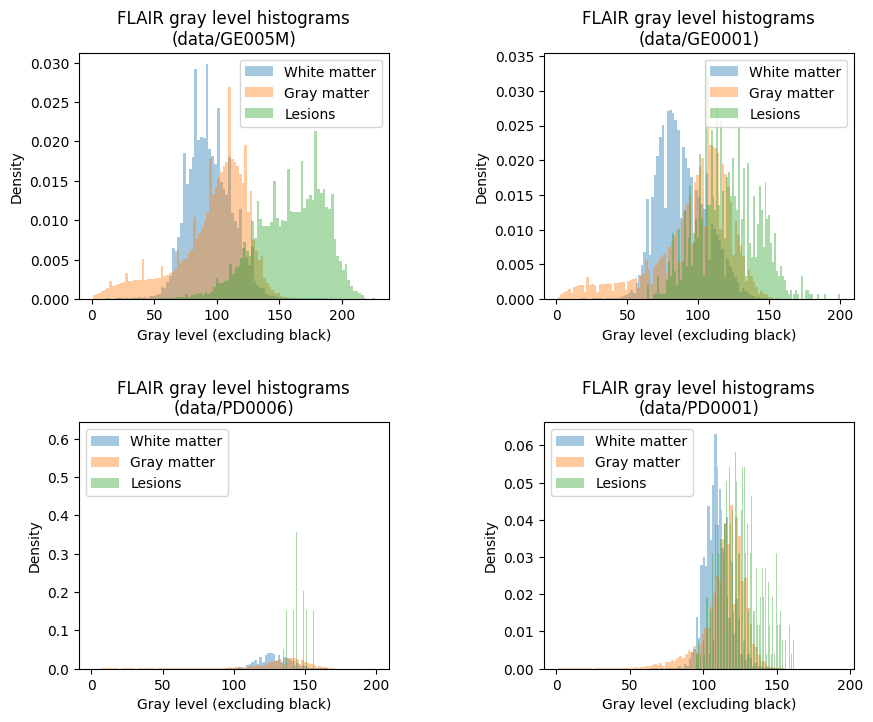

In [ ]:
roots = paths_df.index
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.subplots_adjust(wspace=0.5, hspace=0.5)


for i, root in enumerate(roots):

    print(f"Loading image {paths_df.loc[root, flair_file]}...")
    flair = sitk.ReadImage(paths_df.loc[root, flair_file])
    flair = to_n_bit(flair, 8)
    flair = orient_image(flair, "RAS")

    print("Computing ground truth and segmentation masks...")

    # ground truth
    gt_mask = sitk.ReadImage(paths_df.loc[root, gt_file])
    gt_mask = resample_to_reference(gt_mask, flair)
    gt_mask = sitk.Cast(gt_mask, sitk.sitkUInt8)
    gt = sitk.Mask(flair, gt_mask)

    
    # mask from segmentation
    segm = sitk.ReadImage(paths_df.loc[root, segm_file])
    segm = resample_to_reference(segm, flair)
    gm_mask = get_mask_from_segmentation(segm, gm_labels)
    gm = sitk.Mask(flair, gm_mask)
    wm_mask = get_mask_from_segmentation(segm, wm_labels)
    wm = sitk.Mask(flair, wm_mask)

    print("Computing histogram...")

    ax = axes[i//2, i%2]
    plot_multiple_histograms([wm, gm, gt], no_bkg=True, normalize=True, bins = [100,100,100],
                             labels=["White matter", "Gray matter", "Lesions"], beta = 0.4, ax=ax,
                             title=f"FLAIR gray level histograms\n({root})")

Ora stessa cosa ma col T1.
  
Le lesioni risultano:  
    - simili rispetto a WM (male)  
    - molto iperintense rispetto a GM (bene)  

Loading image data/train/GE005M/T1ontoFLAIR.nii...


NameError: name 'to_n_bit' is not defined

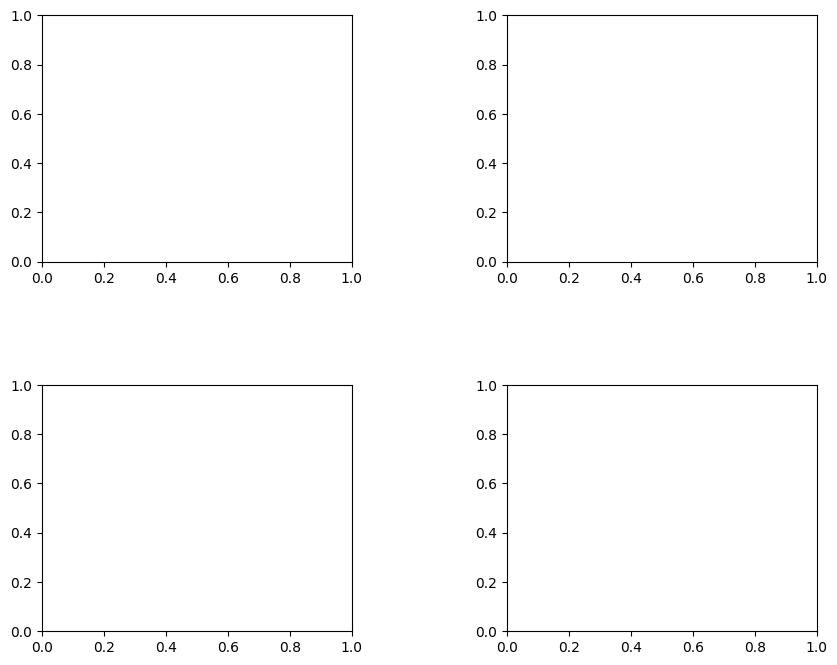

In [8]:
roots = paths_df.index
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i, root in enumerate(roots):

    print(f"Loading image {paths_df.loc[root, t1_file]}...")
    t1 = sitk.ReadImage(paths_df.loc[root, t1_file])
    t1 = to_n_bit(t1, 16)
    t1 = orient_image(t1, "RAS")


    print("Computing ground truth and segmentation masks...")

    # ground truth
    gt_mask = sitk.ReadImage(paths_df.loc[root, gt_file])
    gt_mask = resample_to_reference(gt_mask, t1)
    gt_mask = sitk.Cast(gt_mask, sitk.sitkUInt8)
    gt = sitk.Mask(t1, gt_mask)
    
    # mask from segmentation
    segm = sitk.ReadImage(paths_df.loc[root, segm_file])
    segm = resample_to_reference(segm, t1)
    gm_mask = get_mask_from_segmentation(segm, gm_labels)
    gm = sitk.Mask(t1, gm_mask)
    wm_mask = get_mask_from_segmentation(segm, wm_labels)
    wm = sitk.Mask(t1, wm_mask)
    
    print("Computing histogram...")

    ax = axes[i//2, i%2]
    plot_multiple_histograms([wm, gm, gt], no_bkg=True, normalize=True, bins=[100,100,100],
                             labels=["White matter", "Gray matter", "Lesion"],
                             title=f"T1 gray level histograms\n({root})", ax=ax)

Plottiamo ancora T1, ma applicando una trasformazione gaussiana centrata sulla WM. Vediamo che:  
    - WM e lesioni sono più chiare  
    - GM è più scura

Loading image data/GE005M/T1ontoFLAIR.nii...
Computing ground truth and segmentation masks...
Applying transform...
WM mean: 17396.51, WM std: 1267.84
Computing histogram...
Loading image data/GE0001/T1ontoFLAIR.nii...
Computing ground truth and segmentation masks...
Applying transform...
WM mean: 20182.47, WM std: 1239.62
Computing histogram...
Loading image data/PD0006/T1ontoFLAIR.nii...
Computing ground truth and segmentation masks...
Applying transform...
WM mean: 26030.71, WM std: 2473.71
Computing histogram...
Loading image data/PD0001/T1ontoFLAIR.nii...
Computing ground truth and segmentation masks...
Applying transform...
WM mean: 29923.49, WM std: 1706.68
Computing histogram...


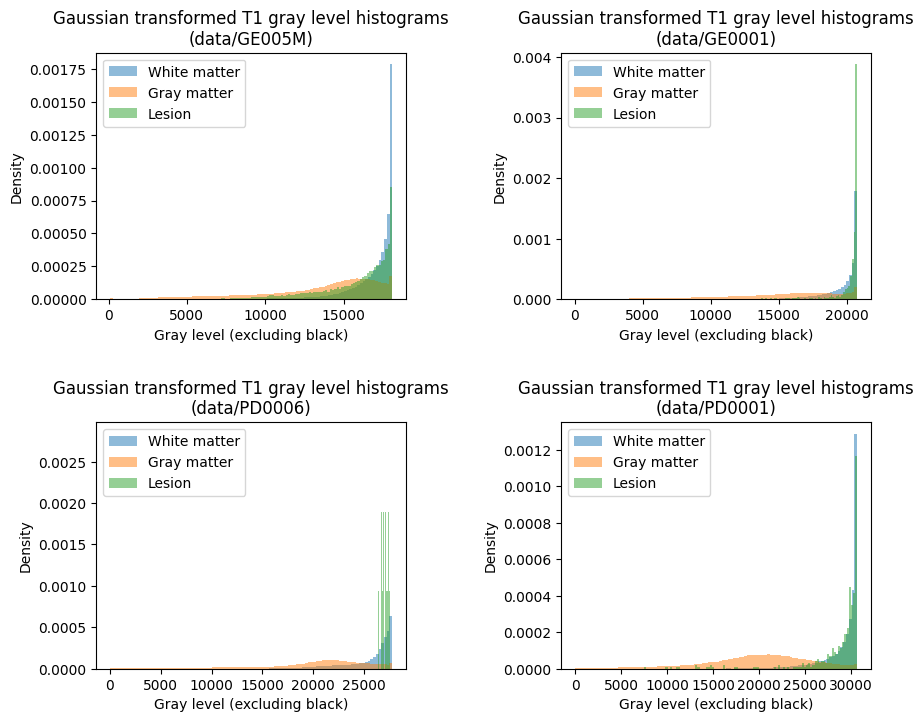

In [5]:
roots = paths_df.index
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i, root in enumerate(roots):

    print(f"Loading image {paths_df.loc[root, t1_file]}...")
    t1 = sitk.ReadImage(paths_df.loc[root, t1_file])
    t1 = to_n_bit(t1, 16)
    t1 = orient_image(t1, "RAS")

    print("Computing ground truth and segmentation masks...")

    # ground truth
    gt_mask = sitk.ReadImage(paths_df.loc[root, gt_file])
    gt_mask = resample_to_reference(gt_mask, t1)
    gt_mask = sitk.Cast(gt_mask, sitk.sitkUInt8)
    
    # mask from segmentation
    segm = sitk.ReadImage(paths_df.loc[root, segm_file])
    segm = resample_to_reference(segm, t1)
    gm_mask = get_mask_from_segmentation(segm, gm_labels)
    wm_mask = get_mask_from_segmentation(segm, wm_labels)
    wm = sitk.Mask(t1, wm_mask)
    all_the_rest_mask = sitk.BinaryNot(wm_mask | gm_mask | gt_mask)



    print("Applying transform...")
    stats = sitk.LabelStatisticsImageFilter()
    stats.Execute(t1, wm_mask)
    wm_mean = stats.GetMean(1)
    wm_std = stats.GetSigma(1)
    t1_gauss = gaussian_transform(t1, mean=wm_mean, std=4*wm_std)
    print(f"WM mean: {wm_mean:.2f}, WM std: {wm_std:.2f}")
    
    wm = sitk.Mask(t1_gauss, wm_mask)
    gm = sitk.Mask(t1_gauss, gm_mask)
    gt = sitk.Mask(t1_gauss, gt_mask)
    all_the_rest = sitk.Mask(t1_gauss, all_the_rest_mask)


    ax = axes[i//2, i%2]

    print("Computing histogram...")
    
    plot_multiple_histograms([wm, gm, gt], no_bkg=True, normalize=True, bins=[100,100,100],
                             labels=["White matter", "Gray matter", "Lesion"],
                             title=f"Gaussian transformed T1 gray level histograms\n"+
                             f"({root})", ax=ax)

Ora valutiamo (1 + t1_gauss) * FLAIR. Regoliamo il parametro beta che decide la deviazione standard di t1_gauss.

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

beta = 1

# Dizionario dove salviamo media, Q1, Q3 e IQR per ogni root e beta
stats_data = {}  # stats_data[root][alpha][tissue]['mean'/'q1'/'q3'/'iqr']

def compute_stats(image_sitk):
    arr = sitk.GetArrayFromImage(image_sitk)
    arr = arr[arr > 0]  # togli sfondo
    if arr.size == 0:
        return 0.0, 0.0, 0.0, 0.0
    mean = float(np.mean(arr))
    q1 = float(np.percentile(arr, 25))
    q3 = float(np.percentile(arr, 75))
    iqr = q3 - q1
    return mean, q1, q3, iqr


roots = paths_df.index

for alpha in np.linspace(1, 10, 10):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    for i, root in enumerate(roots):
        print(f"Processing ROOT={root}, ALPHA={alpha}")
        if root not in stats_data:
            stats_data[root] = {}
        if alpha not in stats_data[root]:
            stats_data[root][alpha] = {}

        flair = sitk.ReadImage(paths_df.loc[root, flair_file])
        flair = to_n_bit(flair, 16)
        flair = orient_image(flair, "RAS")

        t1 = sitk.ReadImage(paths_df.loc[root, t1_file])
        t1 = to_n_bit(t1, 16)
        t1 = resample_to_reference(t1, flair)

        gt_mask = sitk.ReadImage(paths_df.loc[root, gt_file])
        gt_mask = resample_to_reference(gt_mask, t1)
        gt_mask = sitk.Cast(gt_mask, sitk.sitkUInt8)

        segm = sitk.ReadImage(paths_df.loc[root, segm_file])
        segm = resample_to_reference(segm, flair)
        gm_mask = get_mask_from_segmentation(segm, gm_labels)
        wm_mask = get_mask_from_segmentation(segm, wm_labels)
        all_the_rest_mask = sitk.BinaryNot(wm_mask | gm_mask | gt_mask)

        wm_t1 = sitk.Mask(t1, wm_mask)
        stats = sitk.StatisticsImageFilter()
        stats.Execute(wm_t1)
        wm_mean = stats.GetMean()
        wm_std = stats.GetSigma()
        t1_gauss = gaussian_transform(t1, mean=wm_mean, std=alpha * wm_std,
                                      return_float=True, normalized=False)

        image = (1.0 + beta*t1_gauss) * sitk.Cast(flair, sitk.sitkFloat64)
        image = to_n_bit(image, 16)

        wm = sitk.Mask(image, wm_mask)
        gm = sitk.Mask(image, gm_mask)
        gt = sitk.Mask(image, gt_mask)

        for tissue_name, tissue_img in [('wm', wm), ('gm', gm), ('gt', gt)]:
            mean_val, q1_val, q3_val, iqr_val = compute_stats(tissue_img)
            stats_data[root][alpha][tissue_name] = {
                'mean': mean_val, 'q1': q1_val, 'q3': q3_val, 'iqr': iqr_val
            }

        ax = axes[i // 2, i % 2]
        plot_multiple_histograms(
            [wm, gm, gt], no_bkg=True, normalize=True, bins=[100, 100, 100],
            labels=["White matter", "Gray matter", "Lesion"],
            title=f"alpha = {alpha}\nbeta = {beta}\n({root})", ax=ax
        )

    save_path = os.path.join("analysis", "alpha", f"alpha_{alpha:.1f}.png")
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path)
    plt.close()


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

root_list = list(roots)
for i, root in enumerate(root_list):
    ax = axes[i // 2, i % 2]
    alphas_sorted = sorted(stats_data[root].keys())

    for tissue, label in [('wm', 'White Matter'), ('gm', 'Gray Matter'), ('gt', 'Lesion')]:
        means = [stats_data[root][a][tissue]['mean'] for a in alphas_sorted]
        q1s   = [stats_data[root][a][tissue]['q1'] for a in alphas_sorted]
        q3s   = [stats_data[root][a][tissue]['q3'] for a in alphas_sorted]

        ax.plot(alphas_sorted, means, marker='o', label=f'{label} - mean')
        ax.fill_between(alphas_sorted, q1s, q3s, alpha=0.2, label=f'{label} - Q1–Q3')

    ax.set_title(f"beta = 1\n({root})")
    ax.set_xlabel('Alpha')
    ax.set_ylabel('Value')
    ax.legend()

save_path = os.path.join("analysis", "alpha", "summary_stats.png")
plt.savefig(save_path)
plt.close()


Processing ROOT=data/GE005M, ALPHA=1.0


Qui invece prendiamo alpha = 4 e valutiamo il variare di beta, dove l'immagine è (1 + beta*t1_gauss) * FLAIR

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import gc

# Liste dei parametri
alpha_list = range(1,10)  # esempi di alpha
beta_list = np.linspace(0, 2, 11)  

# Dizionario dove salviamo media, Q1, Q3 e IQR per ogni root, alpha e beta
stats_data = {}  # stats_data[root][alpha][beta][tissue]

def compute_stats(image_sitk):
    arr = sitk.GetArrayFromImage(image_sitk)
    arr = arr[arr > 0]  # togli sfondo
    if arr.size == 0:
        return 0.0, 0.0, 0.0, 0.0
    mean = float(np.mean(arr))
    q1 = float(np.percentile(arr, 25))
    q3 = float(np.percentile(arr, 75))
    iqr = q3 - q1
    return mean, q1, q3, iqr

roots = paths_df.index

for alpha in alpha_list:
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.subplots_adjust(wspace=0.3, hspace=0.3)
    
    # Inizializza stats_data per alpha
    for root in roots:
        if root not in stats_data:
            stats_data[root] = {}
        if alpha not in stats_data[root]:
            stats_data[root][alpha] = {}
    
    for i, root in enumerate(roots):
        ax = axes[i // 2, i % 2]
        
        for beta in beta_list:
            print(f"Processing ROOT={root}, ALPHA={alpha}, BETA={beta:.2f}")
            if beta not in stats_data[root][alpha]:
                stats_data[root][alpha][beta] = {}
            
            flair = sitk.ReadImage(paths_df.loc[root, flair_file])
            flair = to_n_bit(flair, 8)
            flair = orient_image(flair, "RAS")

            t1 = sitk.ReadImage(paths_df.loc[root, t1_file])
            t1 = to_n_bit(t1, 8)
            t1 = resample_to_reference(t1, flair)

            gt_mask = sitk.ReadImage(paths_df.loc[root, gt_file])
            gt_mask = resample_to_reference(gt_mask, t1)
            gt_mask = sitk.Cast(gt_mask, sitk.sitkUInt8)

            segm = sitk.ReadImage(paths_df.loc[root, segm_file])
            segm = resample_to_reference(segm, flair)
            gm_mask = get_mask_from_segmentation(segm, gm_labels)
            wm_mask = get_mask_from_segmentation(segm, wm_labels)
            all_the_rest_mask = sitk.BinaryNot(wm_mask | gm_mask | gt_mask)

            wm_t1 = sitk.Mask(t1, wm_mask)
            stats = sitk.StatisticsImageFilter()
            stats.Execute(wm_t1)
            wm_mean = stats.GetMean()
            wm_std = stats.GetSigma()
            t1_gauss = gaussian_transform(t1, mean=wm_mean, std=alpha * wm_std,
                                          return_float=False)
            
            # Applica beta con NumPy (più sicuro per grandi volumi)
            t1_gauss_arr = beta * get_array_from_image(t1_gauss)
            t1_gauss_scaled = get_image_from_array(t1_gauss_arr,
                                                   sitk.Cast(t1_gauss, sitk.sitkUInt16))

            # Combina con flair
            image = sitk.Cast(flair, sitk.sitkUInt16) + t1_gauss_scaled
            image = to_n_bit(image, 16)

            wm = sitk.Mask(image, wm_mask)
            gm = sitk.Mask(image, gm_mask)
            gt = sitk.Mask(image, gt_mask)
            
            # Calcola statistiche
            for tissue_name, tissue_img in [('wm', wm), ('gm', gm), ('gt', gt)]:
                mean_val, q1_val, q3_val, iqr_val = compute_stats(tissue_img)
                stats_data[root][alpha][beta][tissue_name] = {
                    'mean': mean_val, 'q1': q1_val, 'q3': q3_val, 'iqr': iqr_val
                }
            
            gc.collect()
        
        # Plotta media e Q1-Q3 per tutti i beta
        betas_sorted = sorted(stats_data[root][alpha].keys())
        for tissue, label in [('wm', 'White Matter'), ('gm', 'Gray Matter'), ('gt', 'Lesion')]:
            means = [stats_data[root][alpha][b][tissue]['mean'] for b in betas_sorted]
            q1s   = [stats_data[root][alpha][b][tissue]['q1'] for b in betas_sorted]
            q3s   = [stats_data[root][alpha][b][tissue]['q3'] for b in betas_sorted]

            ax.plot(betas_sorted, means, marker='o', label=f'{label} - mean')
            ax.fill_between(betas_sorted, q1s, q3s, alpha=0.2, label=f'{label} - Q1–Q3')

        ax.set_title(f"Root: {root} - Alpha = {alpha}")
        ax.set_xlabel('Beta')
        ax.set_ylabel('Value')
        ax.legend()
    
    # Salva il grafico per questo alpha
    save_path = os.path.join("analysis", "alpha_beta_summary", f"summary_alpha_{alpha}.png")
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path)
    plt.close()


Processing ROOT=data/GE005M, ALPHA=1, BETA=0.00
Processing ROOT=data/GE005M, ALPHA=1, BETA=0.20
Processing ROOT=data/GE005M, ALPHA=1, BETA=0.40
Processing ROOT=data/GE005M, ALPHA=1, BETA=0.60
Processing ROOT=data/GE005M, ALPHA=1, BETA=0.80
Processing ROOT=data/GE005M, ALPHA=1, BETA=1.00
Processing ROOT=data/GE005M, ALPHA=1, BETA=1.20
Processing ROOT=data/GE005M, ALPHA=1, BETA=1.40
Processing ROOT=data/GE005M, ALPHA=1, BETA=1.60
Processing ROOT=data/GE005M, ALPHA=1, BETA=1.80
Processing ROOT=data/GE005M, ALPHA=1, BETA=2.00
Processing ROOT=data/GE0001, ALPHA=1, BETA=0.00
Processing ROOT=data/GE0001, ALPHA=1, BETA=0.20
Processing ROOT=data/GE0001, ALPHA=1, BETA=0.40
Processing ROOT=data/GE0001, ALPHA=1, BETA=0.60
Processing ROOT=data/GE0001, ALPHA=1, BETA=0.80
Processing ROOT=data/GE0001, ALPHA=1, BETA=1.00
Processing ROOT=data/GE0001, ALPHA=1, BETA=1.20
Processing ROOT=data/GE0001, ALPHA=1, BETA=1.40
Processing ROOT=data/GE0001, ALPHA=1, BETA=1.60
Processing ROOT=data/GE0001, ALPHA=1, BE

Plottiamo anche skewness e kurtosis

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.subplots_adjust(wspace=0.3, hspace=0.3)
tissue_colors = {"WM": "tab:blue", "GM": "tab:orange", "GT": "tab:green"}
x = betas



for i, root in enumerate(roots):
    
    df = stats[i]


    # skew and kurt
    skew = df["GM"].str[4]
    kurt = df["GM"].str[5]

    ax = axes[i//2, i%2]

    ax.plot(x, skew, label="Skewness", linestyle="-")
    ax.plot(x, kurt, label="Kurtosis", linestyle="--")
    ax.set_title(root)

fig.legend(["Skewness","Kurtosis"])
ax.set_xlabel("beta")
ax.set_ylabel("Gray level distribution statistics")

fig.suptitle("Skewness and Kurtosis of GM gray level distribution")


In [ ]:
i=0


image = sitk.ReadImage(paths_df[flair_file][i])
image = orient_image(image, 'RAS')

segm = sitk.ReadImage(paths_df[segm_file][i])
segm = resample_to_reference(segm, image)

gm_mask = get_mask_from_segmentation(segm, gm_labels)
gm = sitk.Mask(image, gm_mask)  

gt = sitk.ReadImage(paths_df[gt_file][i])
gt = resample_to_reference(gt, image)
gt = sitk.Cast(gt, sitk.sitkUInt8)


/tmp/ipykernel_794/98426943.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image = sitk.ReadImage(paths_df[flair_file][i])
/tmp/ipykernel_794/98426943.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  segm = sitk.ReadImage(paths_df[segm_file][i])
/tmp/ipykernel_794/98426943.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gt = sitk.ReadImage(paths_df[gt_file][i])


Sospetto: la coda sinistra dell'istogramma GM è data da contaminazione con altri tessuti meno intensi. Controlliamo!
Eh no purtroppo non si può dire con sicurezza che il PVE è il motivo per cui gli istorgrammi hanno code sinistre molto pesanti.

Folder data/GE005M/GE005M_2017_04_11:
Loading FLAIR...
Loading segmentation...
Computing GM segmentation...
Loading PVEs...
Folder data/GE0001/GE0001_2016_12_21:
Loading FLAIR...
Loading segmentation...
Computing GM segmentation...
Loading PVEs...
Folder data/PD0006/PD0006_2014_06_18:
Loading FLAIR...
Loading segmentation...
Computing GM segmentation...
Loading PVEs...
Folder data/PD0001/PD0001_2019_04_24:
Loading FLAIR...
Loading segmentation...
Computing GM segmentation...
Loading PVEs...


Text(0.5, 0.98, 'Partial Volume Effect of WM and CSF on each gray level')

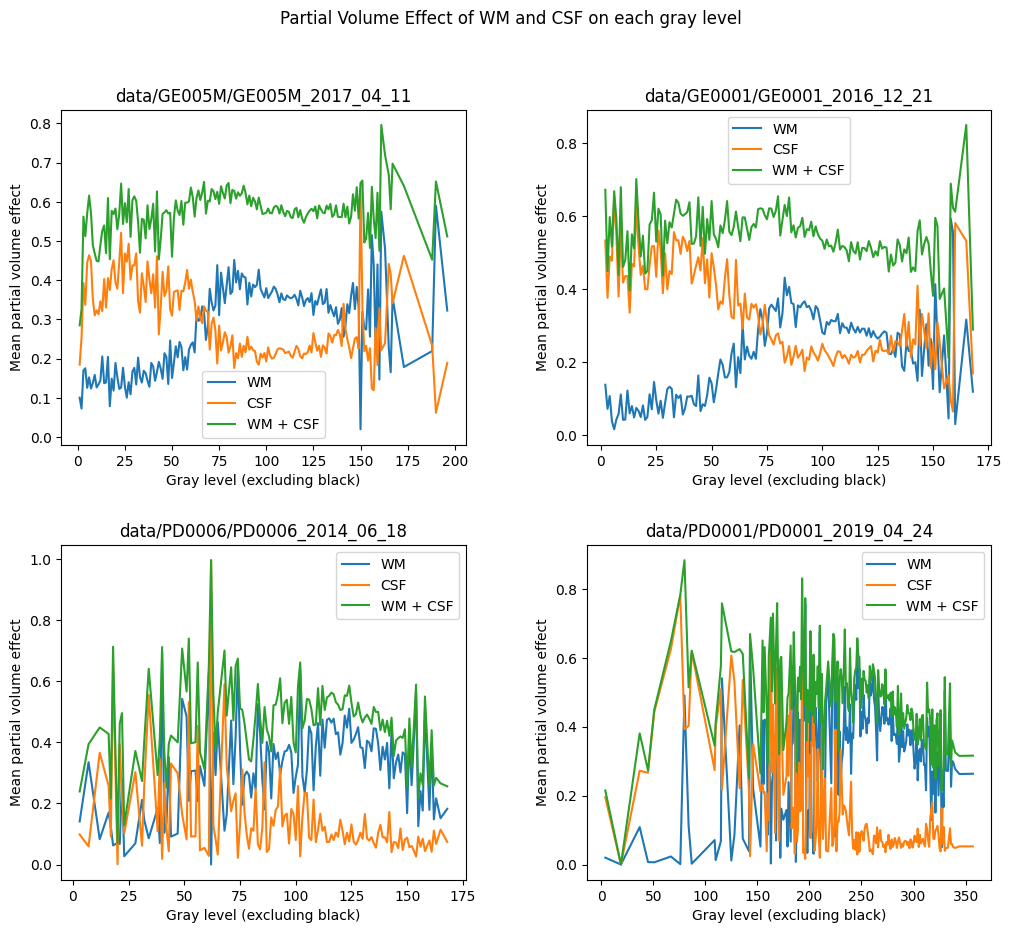

In [ ]:
roots = paths_df.index
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for i, root in enumerate(roots):
    
    print(f"Folder {root}:")

    print("Loading FLAIR...")
    flair = sitk.ReadImage(paths_df.loc[root, flair_file])
    flair = orient_image(flair, "RAS")

    print("Loading segmentation...")
    segm = sitk.ReadImage(paths_df.loc[root, segm_file])
    segm = resample_to_reference(segm, flair)

    print("Computing GM segmentation...")
    gm_mask = get_mask_from_segmentation(segm, gm_labels)
    gm = sitk.Mask(flair, gm_mask) 
    gm_arr = get_array_from_image(gm).flatten()


    print("Loading PVEs...")
    gm_pve = sitk.ReadImage(paths_df.loc[root, gm_pve_file])
    gm_pve = resample_to_reference(gm_pve, flair, sitk.sitkLinear)
    gm_pve_arr = get_array_from_image(gm_pve).flatten()
    wm_pve = sitk.ReadImage(paths_df.loc[root, wm_pve_file])
    wm_pve = resample_to_reference(wm_pve, flair, sitk.sitkLinear)
    wm_pve_arr = get_array_from_image(wm_pve).flatten()
    csf_pve = sitk.ReadImage(paths_df.loc[root, csf_pve_file])
    csf_pve = resample_to_reference(csf_pve, flair, sitk.sitkLinear)
    csf_pve_arr = get_array_from_image(csf_pve).flatten()

    # downsample arrays to save time
    gm_arr = downsample_array(gm_arr, 0.01)
    wm_pve_arr = downsample_array(wm_pve_arr, 0.01)
    gm_pve_arr = downsample_array(gm_pve_arr, 0.01)
    csf_pve_arr = downsample_array(csf_pve_arr, 0.01)
    unique_gl = np.unique(gm_arr)
    unique_gl = unique_gl[unique_gl != 0]  

    # delete variables to save RAM
    del(gm_mask)
    del(segm)
    del(flair)
    del(gm_pve)
    del(wm_pve)
    del(csf_pve)

    wm_pve_stats = pd.DataFrame(index=unique_gl, columns=["mean","25p","75p","sum"])
    gm_pve_stats = pd.DataFrame(index=unique_gl, columns=["mean","25p","75p","sum"])
    csf_pve_stats = pd.DataFrame(index=unique_gl, columns=["mean","25p","75p","sum"])

    for j, gl in enumerate(unique_gl):
        mask = (gm_arr == gl)
        if np.any(mask):
            for pve_arr, stats in [(wm_pve_arr, wm_pve_stats),
                                (gm_pve_arr, gm_pve_stats),
                                (csf_pve_arr, csf_pve_stats)]:
                pve_values = pve_arr[mask]
                stats.loc[gl, "mean"] = np.mean(pve_values)
                stats.loc[gl, "25p"] = np.percentile(pve_values, 25)
                stats.loc[gl, "75p"] = np.percentile(pve_values, 75)
    
    wm_pve_stats = wm_pve_stats.astype(float)
    gm_pve_stats = gm_pve_stats.astype(float)
    csf_pve_stats = csf_pve_stats.astype(float)

    pve_effect = wm_pve_stats["mean"] + csf_pve_stats["mean"]

    ax = axes[i//2, i%2]

    ax.plot(unique_gl, wm_pve_stats["mean"], label="WM")
    ax.plot(unique_gl, csf_pve_stats["mean"], label="CSF")
    ax.plot(unique_gl, pve_effect, label="WM + CSF")

    ax.set_xlabel("Gray level (excluding black)")
    ax.set_ylabel("Mean partial volume effect")
    ax.set_title(f"{root}")
    ax.legend()

plt.suptitle("Partial Volume Effect of WM and CSF on each gray level")

    

Calcoliamo la correlazione tra intensità e PVE WM dei voxel della GM. 

In [ ]:
from scipy.stats import pearsonr, mode

roots = paths_df.index

for i, root in enumerate(roots):
    
    print(f"\n\nFolder {root}:")

    print("Loading FLAIR...")
    flair = sitk.ReadImage(paths_df.loc[root, flair_file])
    flair = orient_image(flair, "RAS")

    print("Loading segmentation...")
    segm = sitk.ReadImage(paths_df.loc[root, segm_file])
    segm = resample_to_reference(segm, flair)

    print("Computing GM segmentation...")
    gm_mask = get_mask_from_segmentation(segm, gm_labels)
    gm = sitk.Mask(flair, gm_mask) 
    gm_arr = get_array_from_image(gm).flatten()

    print("Loading PVEs...")
    wm_pve = sitk.ReadImage(paths_df.loc[root, wm_pve_file])
    wm_pve = resample_to_reference(wm_pve, flair, sitk.sitkLinear)
    wm_pve_arr = get_array_from_image(wm_pve).flatten()
    csf_pve = sitk.ReadImage(paths_df.loc[root, csf_pve_file])
    csf_pve = resample_to_reference(csf_pve, flair, sitk.sitkLinear)
    csf_pve_arr = get_array_from_image(csf_pve).flatten()

    unique_gl = np.unique(gm_arr)
    unique_gl = unique_gl[unique_gl != 0]  

    print("Removing background...")
    mask = (gm_arr != 0)
    gm_arr = gm_arr[mask]       
    wm_pve_arr = wm_pve_arr[mask]       
    csf_pve_arr = csf_pve_arr[mask]

    # delete variables to save RAM
    del(gm_mask)
    del(segm)
    del(flair)
    del(wm_pve)
    del(csf_pve)

    gm_mode = mode(gm_arr)[0]

    print(f"\nComputing correlation between GM intensity and PVEs on the LEFT SIDE OF THE HISTOGRAM (mode={gm_mode}).")

    left_mask = gm_arr <= gm_mode
    gm_arr_left = gm_arr[left_mask]
    wm_pve_arr_left = wm_pve_arr[left_mask]
    csf_pve_arr_left = csf_pve_arr[left_mask]

    r, p_value = pearsonr(gm_arr_left, wm_pve_arr_left)
    print(f"WM PVE correlation: {r:.2f}, p-value: {p_value}")
    r, p_value = pearsonr(gm_arr_left, csf_pve_arr_left)
    print(f"CSF PVE correlation: {r:.2f}, p-value: {p_value}")


    print(f"\nComputing correlation between GM intensity and PVEs on the RIGHT SIDE OF THE HISTOGRAM (mode={gm_mode}).")

    right_mask = gm_arr >= gm_mode
    gm_arr_right = gm_arr[right_mask]
    wm_pve_arr_right = wm_pve_arr[right_mask]
    csf_pve_arr_right = csf_pve_arr[right_mask]

    r, p_value = pearsonr(gm_arr_right, wm_pve_arr_right)
    print(f"WM PVE correlation: {r:.2f}, p-value: {p_value}")
    r, p_value = pearsonr(gm_arr_right, csf_pve_arr_right)
    print(f"CSF PVE correlation: {r:.2f}, p-value: {p_value}")








Folder data/GE005M/GE005M_2017_04_11:
Loading FLAIR...
Loading segmentation...
Computing GM segmentation...
Loading PVEs...
Removing background...

Computing correlation between GM intensity and PVEs on the LEFT SIDE OF THE HISTOGRAM (mode=112.0).
WM PVE correlation: 0.33, p-value: 0.0
CSF PVE correlation: -0.33, p-value: 0.0

Computing correlation between GM intensity and PVEs on the RIGHT SIDE OF THE HISTOGRAM (mode=112.0).
WM PVE correlation: -0.06, p-value: 5.152116216609165e-242
CSF PVE correlation: 0.07, p-value: 0.0


Folder data/GE0001/GE0001_2016_12_21:
Loading FLAIR...
Loading segmentation...
Computing GM segmentation...
Loading PVEs...
Removing background...

Computing correlation between GM intensity and PVEs on the LEFT SIDE OF THE HISTOGRAM (mode=113.0).
WM PVE correlation: 0.27, p-value: 0.0
CSF PVE correlation: -0.37, p-value: 0.0

Computing correlation between GM intensity and PVEs on the RIGHT SIDE OF THE HISTOGRAM (mode=113.0).
WM PVE correlation: -0.08, p-value: 0

Ora guardiamo i valori medi delle PVE per ogni lesione che conosciamo.



Folder data/GE005M/GE005M_2017_04_11:
Loading ground truth...
Loading PVEs...
Computing connected components...
Computing PVE statistics (107 / 107)

Folder data/GE0001/GE0001_2016_12_21:
Loading ground truth...
Loading PVEs...
Computing connected components...
Computing PVE statistics (133 / 133)

Folder data/PD0006/PD0006_2014_06_18:
Loading ground truth...
Loading PVEs...
Computing connected components...
Computing PVE statistics (3 / 3)

Folder data/PD0001/PD0001_2019_04_24:
Loading ground truth...
Loading PVEs...
Computing connected components...


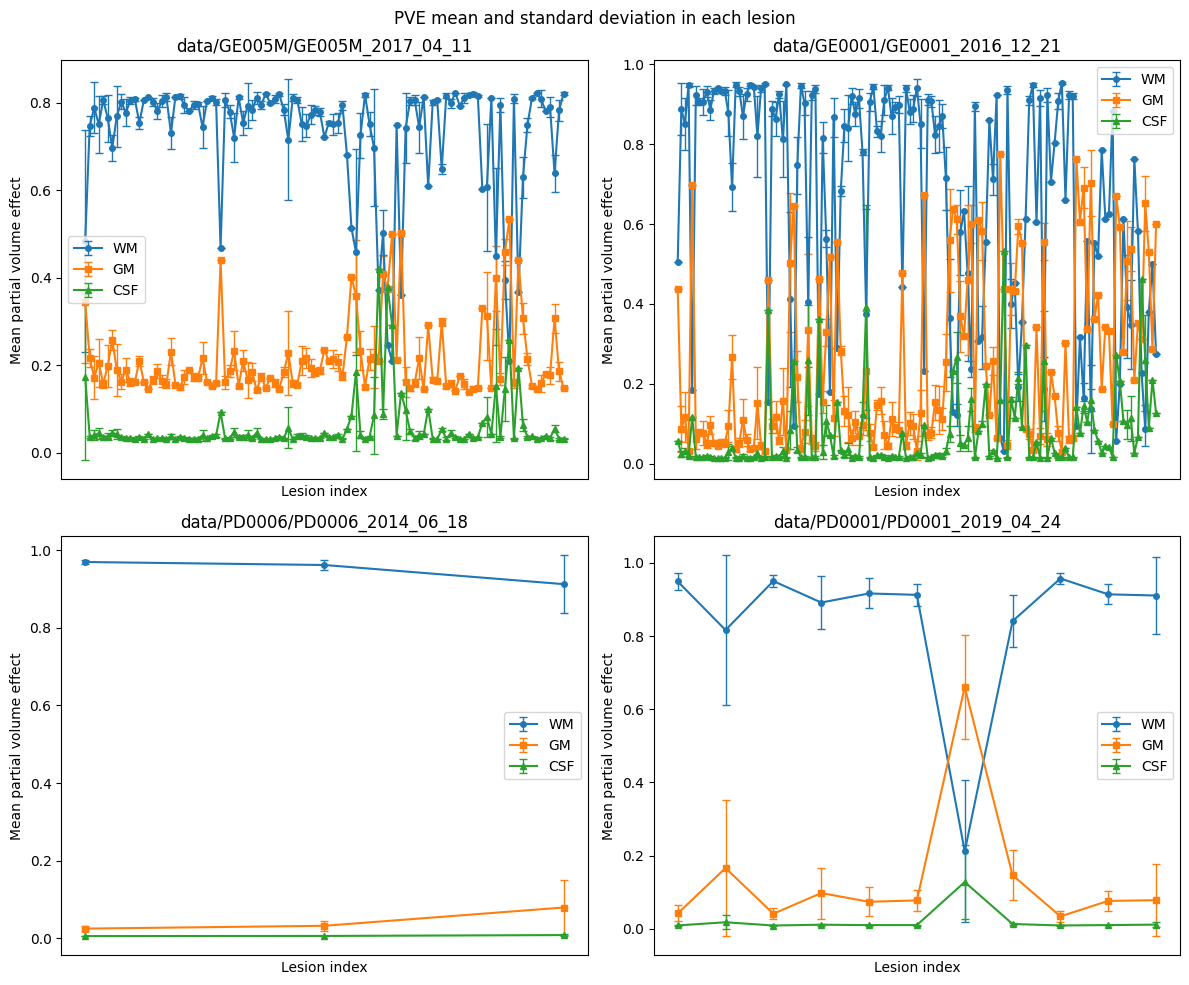

In [ ]:
from SilentInfarctionSegmentationFLAIR.refinement import connected_components


roots = paths_df.index
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for i, root in enumerate(roots):
    
    print(f"\n\nFolder {root}:")

    print("Loading ground truth...")
    gt = sitk.ReadImage(paths_df.loc[root, gt_file])

    print("Loading PVEs...")
    wm_pve = sitk.ReadImage(paths_df.loc[root, wm_pve_file])
    wm_pve = resample_to_reference(wm_pve, gt, sitk.sitkLinear)
    #wm_pve_arr = get_array_from_image(wm_pve)
    gm_pve = sitk.ReadImage(paths_df.loc[root, gm_pve_file])
    gm_pve = resample_to_reference(gm_pve, gt, sitk.sitkLinear)
    #gm_pve_arr = get_array_from_image(gm_pve)
    csf_pve = sitk.ReadImage(paths_df.loc[root, csf_pve_file])
    csf_pve = resample_to_reference(csf_pve, gt, sitk.sitkLinear)
    #csf_pve_arr = get_array_from_image(csf_pve)


    print("Computing connected components...")
    ccs, n_components = connected_components(gt)
    ccs_arr = get_array_from_image(ccs)

    wm_pve_stats = pd.DataFrame(index=range(1, n_components + 1),
                                columns=["mean","std"])
    gm_pve_stats = pd.DataFrame(index=range(1, n_components + 1),
                                columns=["mean","std"])
    csf_pve_stats = pd.DataFrame(index=range(1, n_components + 1),
                                  columns=["mean","std"])


    for label in range(1, n_components + 1):    # from 1 to n_components
        
        print(f"Computing PVE statistics ({label} / {n_components})", end='\r')
        
        for pve, stats in [(wm_pve, wm_pve_stats),
                            (gm_pve, gm_pve_stats),
                            (csf_pve, csf_pve_stats)]:
                filt = sitk.LabelStatisticsImageFilter()
                filt.Execute(pve, ccs)
                stats.loc[label, "mean"] = filt.GetMean(label)
                stats.loc[label, "std"] = filt.GetSigma(label)

    ax = axes[i//2, i%2]

    ax.errorbar(range(1, n_components+1), wm_pve_stats["mean"], yerr=wm_pve_stats["std"], 
               fmt='-o', label="WM", capsize=3, elinewidth=1, markersize=4)
    
    ax.errorbar(range(1, n_components+1), gm_pve_stats["mean"], yerr=gm_pve_stats["std"], 
               fmt='-s', label="GM", capsize=3, elinewidth=1, markersize=4)
    
    ax.errorbar(range(1, n_components+1), csf_pve_stats["mean"], yerr=csf_pve_stats["std"], 
               fmt='-^', label="CSF", capsize=3, elinewidth=1, markersize=4)
    ax.set_xlabel("Lesion index")
    ax.set_ylabel("Mean partial volume effect")
    ax.set_title(f"{root}")
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.legend()

plt.suptitle("PVE mean and standard deviation in each lesion")
plt.tight_layout()

        
    
        

PVE dei voxel attorno



Folder data/GE005M:
Loading ground truth...
Loading PVEs...
Computing connected components...
Computing surrounding PVE means...


Folder data/GE0001:
Loading ground truth...
Loading PVEs...
Computing connected components...
Computing surrounding PVE means...


Folder data/PD0006:
Loading ground truth...
Loading PVEs...
Computing connected components...
Computing surrounding PVE means...


Folder data/PD0001:
Loading ground truth...
Loading PVEs...
Computing connected components...
Computing surrounding PVE means...


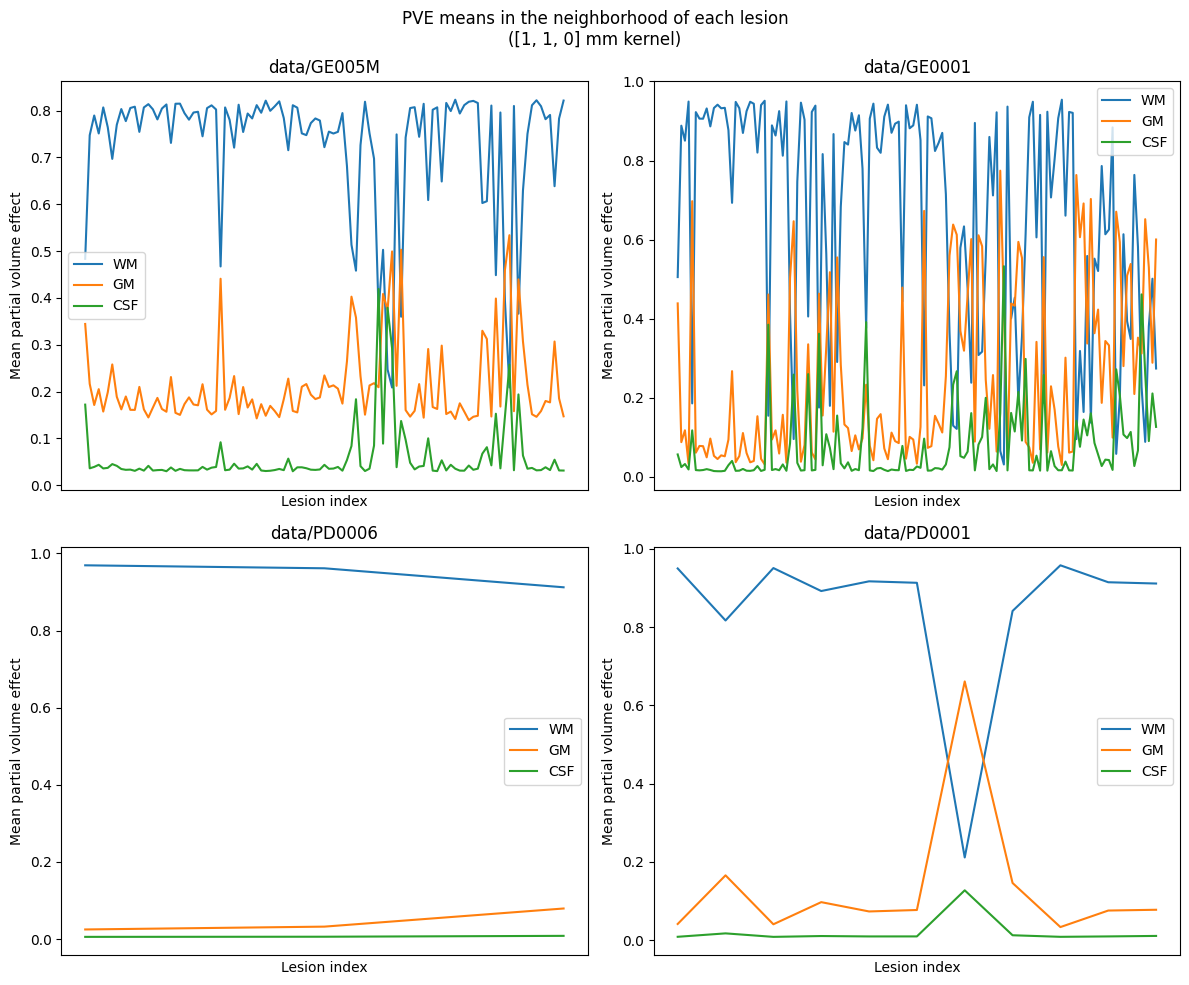

In [ ]:
from SilentInfarctionSegmentationFLAIR.refinement import surrounding_filter

radius = 1

roots = paths_df.index
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for i, root in enumerate(roots):
    
    print(f"\n\nFolder {root}:")

    print("Loading ground truth...")
    gt = sitk.ReadImage(paths_df.loc[root, gt_file])

    print("Loading PVEs...")
    pve_wm = sitk.ReadImage(paths_df.loc[root, wm_pve_file])
    pve_wm = resample_to_reference(pve_wm, gt, sitk.sitkLinear)
    #wm_pve_arr = get_array_from_image(wm_pve)
    pve_gm = sitk.ReadImage(paths_df.loc[root, gm_pve_file])
    pve_gm = resample_to_reference(pve_gm, gt, sitk.sitkLinear)
    #gm_pve_arr = get_array_from_image(gm_pve)
    pve_csf = sitk.ReadImage(paths_df.loc[root, csf_pve_file])
    pve_csf = resample_to_reference(pve_csf, gt, sitk.sitkLinear)
    #csf_pve_arr = get_array_from_image(csf_pve)


    print("Computing connected components...")
    ccs, n_components = connected_components(gt)

    print("Computing surrounding PVE means...")
    _, _, stats = surrounding_filter(ccs, n_components, [pve_wm, pve_gm, pve_csf], dilation_radius=radius)
    
    ax = axes[i//2, i%2]

    ax.plot(stats)    
    ax.set_xlabel("Lesion index")
    ax.set_ylabel("Mean partial volume effect")
    ax.set_title(f"{root}")
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.legend(labels=["WM","GM","CSF"])

plt.suptitle("PVE means in the neighborhood of each lesion\n"+
             f"({nearly_isotropic_kernel(gt.GetSpacing(), radius)} mm kernel)")
plt.tight_layout()
    
        

Adesso vediamo come le lesioni sono classificate nelle segmentazioni (per ogni voxel)



Folder data/GE005M/GE005M_2017_04_11:
Loading ground truth...
Loading segmentation...
Counting labels...
Zio cane


Folder data/GE0001/GE0001_2016_12_21:
Loading ground truth...
Loading segmentation...
Counting labels...


MaskImageFilter (0x7ffcb3578620): Support for pixel type 16-bit signed integer for the MaskImage input has been deprecated and will be removed in future versions. Implicitly casting input to support 'sitkUInt8' type. 

Zio cane


Folder data/PD0006/PD0006_2014_06_18:
Loading ground truth...
Loading segmentation...
Counting labels...
Zio cane


Folder data/PD0001/PD0001_2019_04_24:
Loading ground truth...
Loading segmentation...
Counting labels...
Zio cane


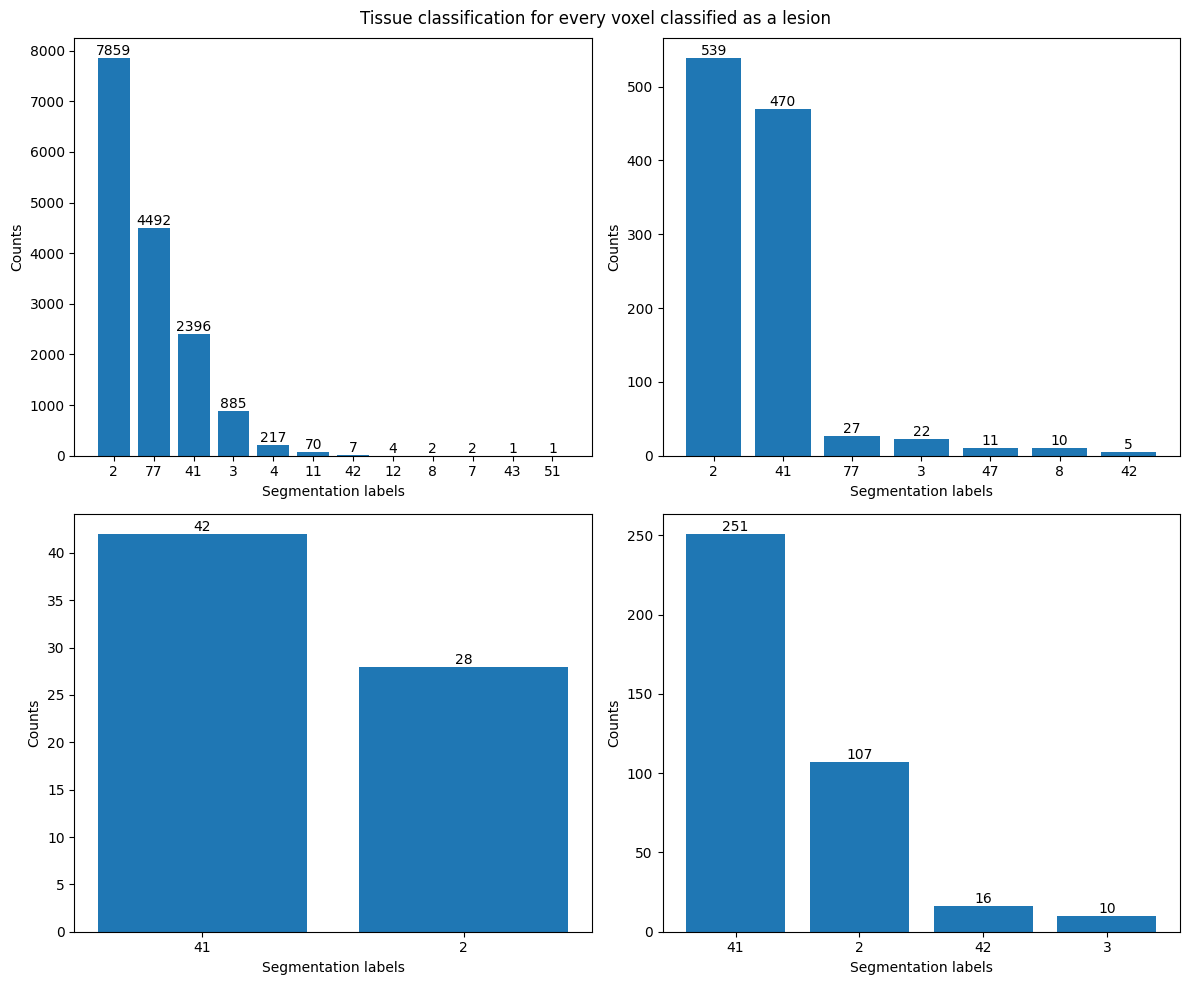

In [ ]:
from SilentInfarctionSegmentationFLAIR.refinement import connected_components
from collections import Counter


roots = paths_df.index
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for i, root in enumerate(roots):
    
    print(f"\n\nFolder {root}:")

    print("Loading ground truth...")
    gt = sitk.ReadImage(paths_df.loc[root, gt_file])

    print("Loading segmentation...")
    segm = sitk.ReadImage(paths_df.loc[root, segm_file])
    segm = resample_to_reference(segm, gt)

    print("Counting labels...")
    gt_segm = sitk.Mask(segm, gt)
    gt_segm_arr = get_array_from_image(gt_segm)
    gt_segm_arr = gt_segm_arr[gt_segm_arr != 0]

    unique_values, counts = np.unique(gt_segm_arr, return_counts=True)
    sorted_indices = np.argsort(counts)[::-1]
    sorted_values = unique_values[sorted_indices]
    sorted_counts = counts[sorted_indices]

    ax = axes[i//2, i%2]


    bars = ax.bar(sorted_values.astype(str), sorted_counts)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

    ax.set_xlabel('Segmentation labels')
    ax.set_ylabel('Counts')
    ax.set_title(root)


plt.suptitle("Tissue classification for every voxel classified as a lesion")
plt.tight_layout()

Ora proviamo ad essere più severi. Per ogni lesione mostriamo come è classificata LA MAGGIOR PARTE dei voxel.



Folder data/GE005M/GE005M_2017_04_11:
Loading ground truth...
Loading segmentation...
Computing connected components...
Counting labels...


Folder data/GE0001/GE0001_2016_12_21:
Loading ground truth...
Loading segmentation...
Computing connected components...
Counting labels...


MaskImageFilter (0x7ffcb3578620): Support for pixel type 16-bit signed integer for the MaskImage input has been deprecated and will be removed in future versions. Implicitly casting input to support 'sitkUInt8' type. 



Folder data/PD0006/PD0006_2014_06_18:
Loading ground truth...
Loading segmentation...
Computing connected components...
Counting labels...


Folder data/PD0001/PD0001_2019_04_24:
Loading ground truth...
Loading segmentation...
Computing connected components...
Counting labels...


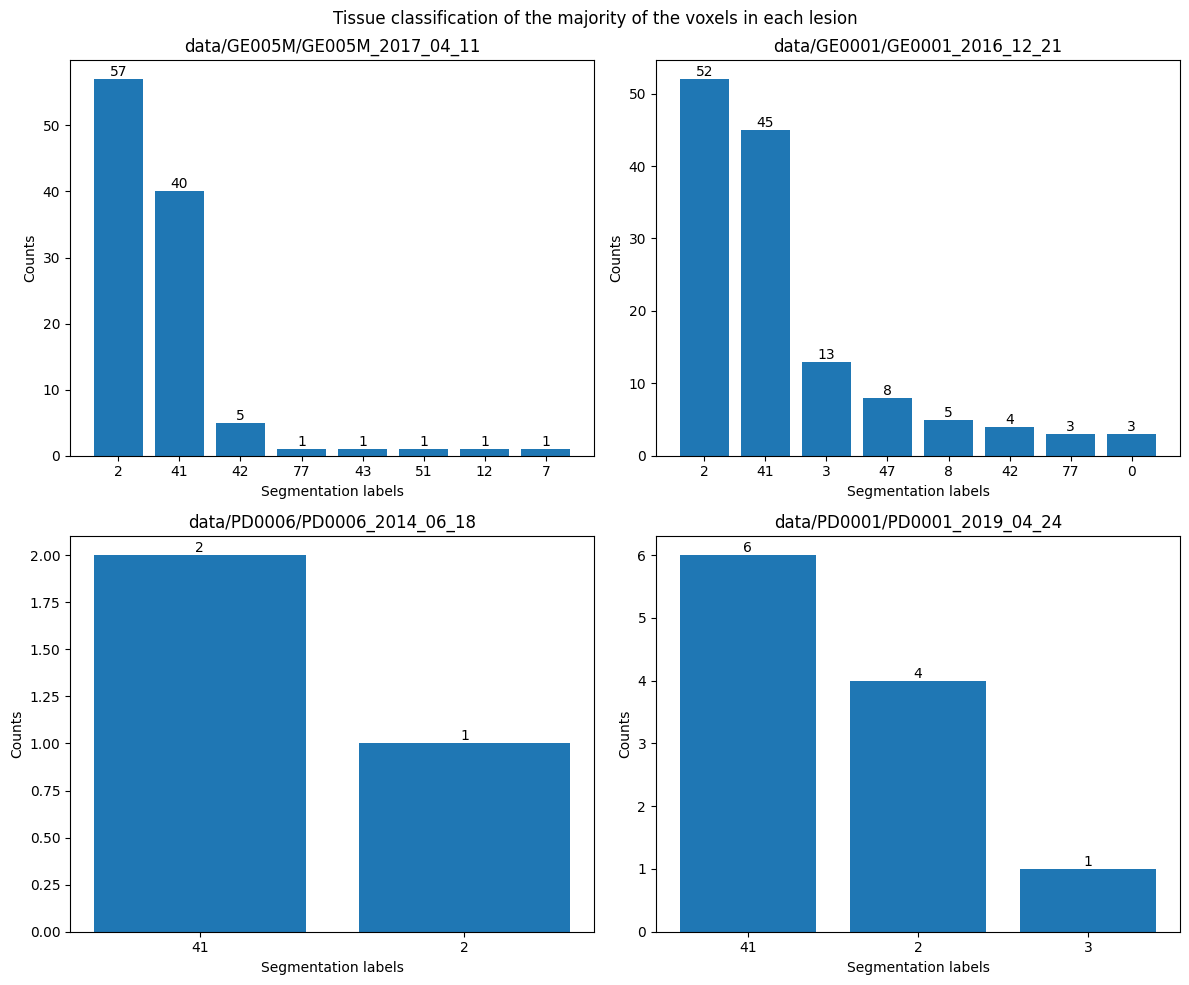

In [ ]:
from SilentInfarctionSegmentationFLAIR.refinement import connected_components
from scipy.ndimage import labeled_comprehension
from collections import Counter


def fast_mode(values):
    if values.size == 0:
        return None
    vals, counts = np.unique(values, return_counts=True)
    return vals[np.argmax(counts)]

roots = paths_df.index
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for i, root in enumerate(roots):
    
    print(f"\n\nFolder {root}:")

    print("Loading ground truth...")
    gt = sitk.ReadImage(paths_df.loc[root, gt_file])

    print("Loading segmentation...")
    segm = sitk.ReadImage(paths_df.loc[root, segm_file])
    segm = resample_to_reference(segm, gt)

    print("Computing connected components...")

    ccs, n_components = connected_components(gt)
    ccs_arr = get_array_from_image(ccs)

    print("Counting labels...")
    gt_segm = sitk.Mask(segm, gt)
    gt_segm_arr = get_array_from_image(gt_segm)

    modes = labeled_comprehension(gt_segm_arr, ccs_arr, np.arange(1, n_components + 1),
                                      fast_mode, int, 0)
    
    unique_values, counts = np.unique(modes, return_counts=True)
    sorted_indices = np.argsort(counts)[::-1]
    sorted_values = unique_values[sorted_indices]
    sorted_counts = counts[sorted_indices]

    ax = axes[i//2, i%2]


    bars = ax.bar(sorted_values.astype(str), sorted_counts)

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')

    ax.set_xlabel('Segmentation labels')
    ax.set_ylabel('Counts')
    ax.set_title(root)



plt.suptitle("Tissue classification of the majority of the voxels in each lesion")
plt.tight_layout()

Ora guardiamo la distribuzione dei diametri e numero di pixel delle componenti connesse



Folder data/GE005M:
Loading ground truth...
Computing connected components...
Counting diameters...


Folder data/GE0001:
Loading ground truth...
Computing connected components...
Counting diameters...


Folder data/PD0006:
Loading ground truth...
Computing connected components...
Counting diameters...


Folder data/PD0001:
Loading ground truth...
Computing connected components...
Counting diameters...


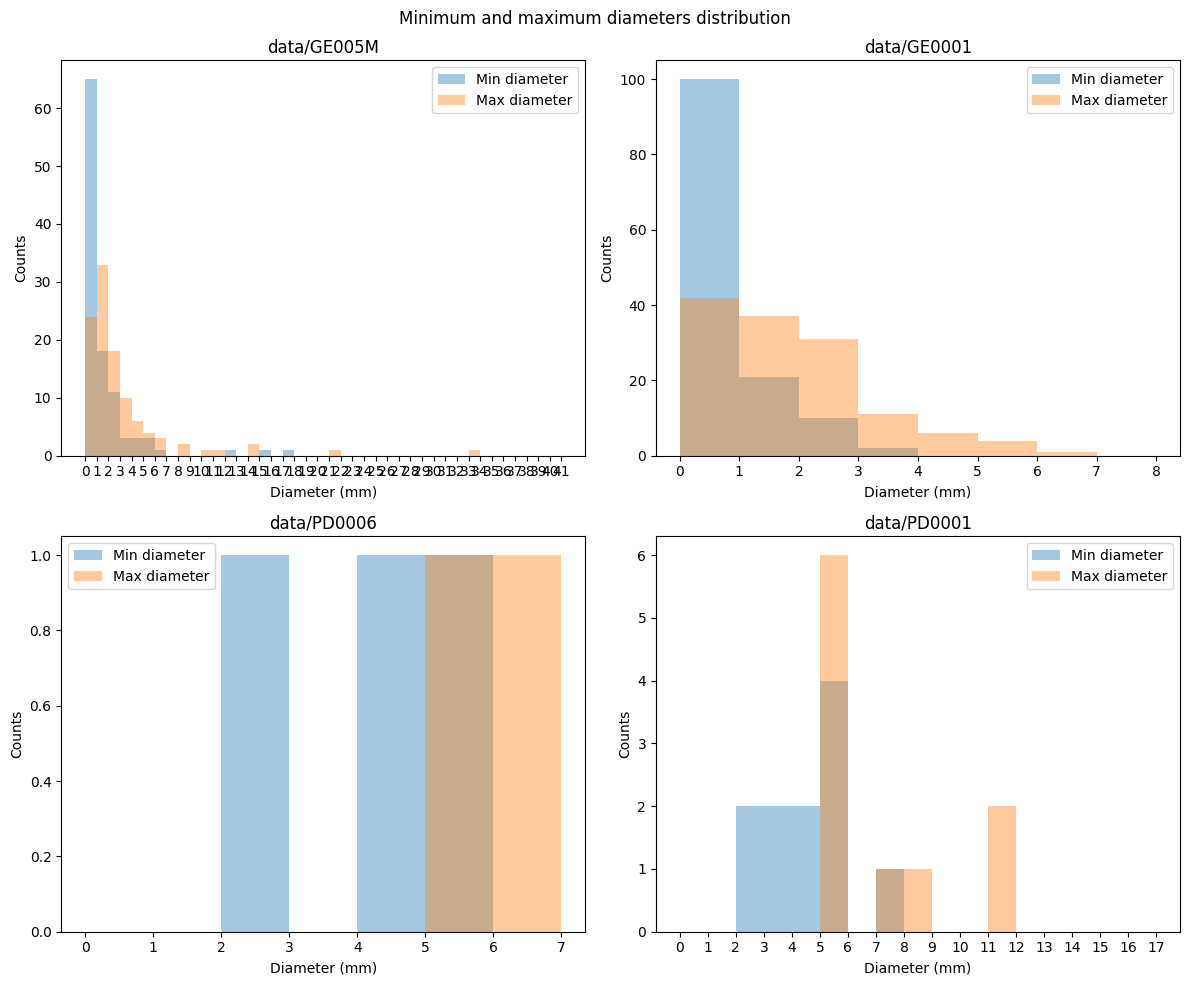

In [ ]:
from SilentInfarctionSegmentationFLAIR.refinement import find_diameters


roots = paths_df.index
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for i, root in enumerate(roots):
    
    print(f"\n\nFolder {root}:")

    print("Loading ground truth...")
    gt = sitk.ReadImage(paths_df.loc[root, gt_file])

    print("Computing connected components...")

    ccs, n_components = connected_components(gt)

    print("Counting diameters...")
    diameters = find_diameters(ccs)
    min_diam = np.array([v[0] for v in diameters.values()])
    max_diam = np.array([v[1] for v in diameters.values()])    
    

    ax = axes[i//2, i%2]

    bins = range(int(max_diam.max())+1)

    counts, bin_edges, _ = ax.hist(min_diam, bins=bins, alpha=0.4, label='Min diameter')
    ax.hist(max_diam, bins=bins, alpha=0.4, label='Max diameter')
    ax.set_xlabel('Diameter (mm)')
    ax.set_ylabel('Counts')
    ax.set_title(root)
    ax.legend()
    ax.set_xticks(bins)
    #ax.set_xticklabels([f"{b:.0f}" for b in bins])

plt.suptitle("Minimum and maximum diameters distribution")
plt.tight_layout()

Quale gamma?????? Guardiamo metriche di valutazione

In [4]:
import time
import gc

importlib.reload(utils)
importlib.reload(segmentation)
importlib.reload(histograms)
importlib.reload(threshold)
importlib.reload(refinement)
importlib.reload(refinement_step)

from SilentInfarctionSegmentationFLAIR.utils import progress_bar
sitk.ProcessObject.SetGlobalDefaultNumberOfThreads(1)


labels_dict = label_names("data/FreeSurferColorLUT.txt")
keywords_to_remove = [
    "Bone", "Teeth", "Cranium", "Skull", "Table", "Diploe", "Endosteum", "Periosteum",
    "CSF", "Ventricle", "Humor", "Lens", "Globe", "Choroid",
    "Epidermis", "Scalp", "Skin", "Dura",
    "Air", "Nasal"
]
processing_steps = ["after threshold",
                    "after refinement step"]

roots = paths_df.index
for i, root in enumerate(roots):
    
    gammas = np.linspace(0, 3, 8).round(2)

    # preallocate dfs
    metrics_dfs = {step: pd.DataFrame(index=gammas,
                                  columns=["TPF","FPF","DSC"])
               for step in processing_steps}

    # prepare folder for saving
    rel_root = os.path.relpath(root, "data")
    anal_path = os.path.join("analysis", rel_root)
    os.makedirs(anal_path, exist_ok=True)


    # load images
    print("Loading...")
    flair = sitk.ReadImage(paths_df.loc[root, flair_file])
    flair = to_n_bit(flair, 8)
    flair = orient_image(flair, "RAS")
    t1 = sitk.ReadImage(paths_df.loc[root, t1_file])
    t1 = to_n_bit(t1, 8)
    t1 = resample_to_reference(t1, flair, interpolator=sitk.sitkLinear)
    gt = sitk.ReadImage(paths_df.loc[root, gt_file])
    gt = resample_to_reference(gt, flair)
    gt = sitk.Cast(gt, sitk.sitkUInt8)
    segm = sitk.ReadImage(paths_df.loc[root, segm_file])
    segm = resample_to_reference(segm, flair)
    gm_mask = get_mask_from_segmentation(segm, gm_labels)
    gm = sitk.Mask(flair, gm_mask)
    wm_pve = sitk.ReadImage(paths_df.loc[root, wm_pve_file])
    wm_pve = resample_to_reference(wm_pve, flair)
    gm_pve = sitk.ReadImage(paths_df.loc[root, gm_pve_file])
    gm_pve = resample_to_reference(gm_pve, flair)
    csf_pve = sitk.ReadImage(paths_df.loc[root, csf_pve_file])
    csf_pve = resample_to_reference(csf_pve, flair)
    pves = [wm_pve, gm_pve, csf_pve]    
    gc.collect()

    gamma_start_time = time.time()
    print("Evaluating...")
    for j, gamma in enumerate(gammas):

        thr_mask = threshold.main(flair, gm,
                                        gamma=gamma, show=False, verbose=False)
        ref_mask = refinement_step.main(
                            thr_mask,
                            image=flair,
                            pves=pves,
                            min_diameter=1,
                            extend_dilation_radius=5,
                            n_std=2,
                            surround_dilation_radius=1,
                            labels_dict=labels_dict,
                            keywords_to_remove=keywords_to_remove,
                            min_points=3,
                            verbose=False)

        
        masks = [thr_mask, ref_mask]      
                 
        for mask, step in zip(masks, processing_steps):
            # evaluate
            metrics_vw = evaluate_voxel_wise(mask, gt)
            # organize in df
            for k, v in metrics_vw.items():
                metrics_dfs[step].loc[gamma, k] = v
        
        gc.collect()
        progress_bar(j, len(gammas), gamma_start_time,
                 prefix=f"Folder: {root} ({i+1}/{len(roots)}), gamma = {gamma:.2f}")

    # save everything            
    for step, df in metrics_dfs.items():
        save_path = os.path.join(anal_path, f"evaluation metrics {step}.pkl")
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        df.to_pickle(save_path)
        


Loading...
Evaluating...
Folder: data/GE005M (1/4), gamma = 3.00 |████████████████████████████████████████| 100.0% (8/8) ETA: 0:00:00           
Loading...
Evaluating...


: 

Metriche voxel-wise

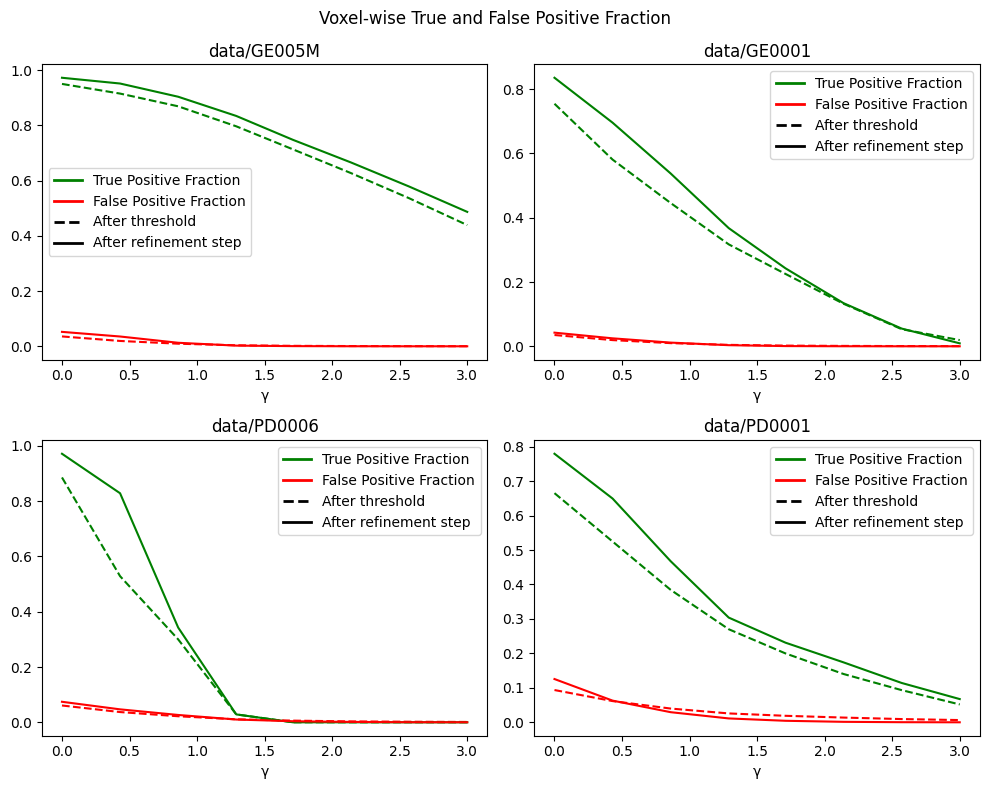

In [10]:
from matplotlib.lines import Line2D

processing_steps = [
    "after threshold",
    "after refinement step"
]

roots = paths_df.index
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i, root in enumerate(roots):

    rel_root = os.path.relpath(root, "data")
    anal_path = os.path.join("analysis", rel_root)
    
    results_thr = pd.read_pickle(os.path.join(anal_path, "evaluation metrics after threshold.pkl"))
    results_ref = pd.read_pickle(os.path.join(anal_path, "evaluation metrics after refinement step.pkl"))

    gammas = np.unique(results_thr.index)

    ax = axes[i//2, i%2]

    ax.plot(gammas, results_thr["vw-TPF"], color="green", linestyle="--")        
    ax.plot(gammas, results_thr["vw-FPF"], color="red", linestyle="--")
    ax.plot(gammas, results_ref["vw-TPF"], color="green", linestyle="-")
    ax.plot(gammas, results_ref["vw-FPF"], color="red", linestyle="-")

    ax.legend(handles= [
        Line2D([0], [0], color="green", lw=2, label="True Positive Fraction"),
        Line2D([0], [0], color="red", lw=2, label="False Positive Fraction"),
        Line2D([0], [0], color="black", linestyle="--", lw=2, label="After threshold"),
        Line2D([0], [0], color="black", linestyle="-", lw=2, label="After refinement step"),
        ])
    
    ax.set_xlabel("γ")
    ax.set_title(root)
    
    
plt.suptitle("Voxel-wise True and False Positive Fraction")
plt.tight_layout()


    



DICE

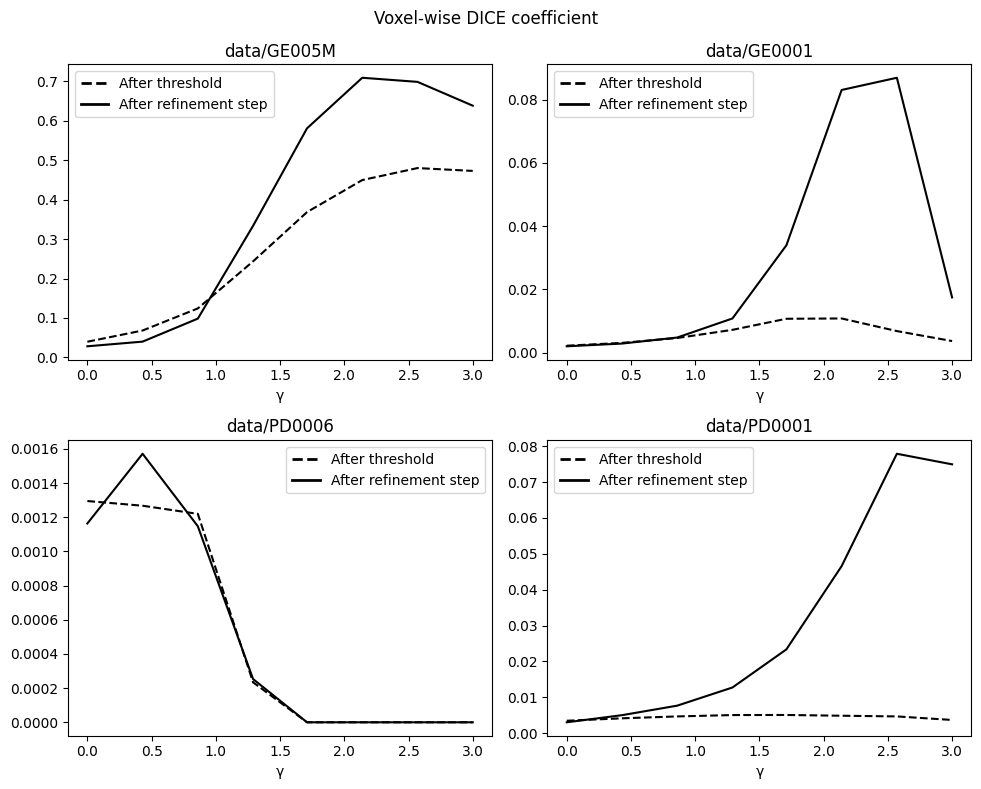

In [11]:
from matplotlib.lines import Line2D

processing_steps = [
    "after threshold",
    "after refinement step"
]

roots = paths_df.index
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i, root in enumerate(roots):

    rel_root = os.path.relpath(root, "data")
    anal_path = os.path.join("analysis", rel_root)
    
    results_thr = pd.read_pickle(os.path.join(anal_path, "evaluation metrics after threshold.pkl"))
    results_ref = pd.read_pickle(os.path.join(anal_path, "evaluation metrics after refinement step.pkl"))

    gammas = np.unique(results_thr.index)

    ax = axes[i//2, i%2]

    ax.plot(gammas, results_thr["vw-DSC"], color="black", linestyle="--")        
    ax.plot(gammas, results_ref["vw-DSC"], color="black", linestyle="-")

    ax.legend(handles= [
        Line2D([0], [0], color="black", lw=2, linestyle="--", label="After threshold"),
        Line2D([0], [0], color="black", lw=2, linestyle="-", label="After refinement step"),
    ])
    
    ax.set_xlabel("γ")
    ax.set_title(root)
    
    
plt.suptitle("Voxel-wise DICE coefficient")
plt.tight_layout()


    



Matthews

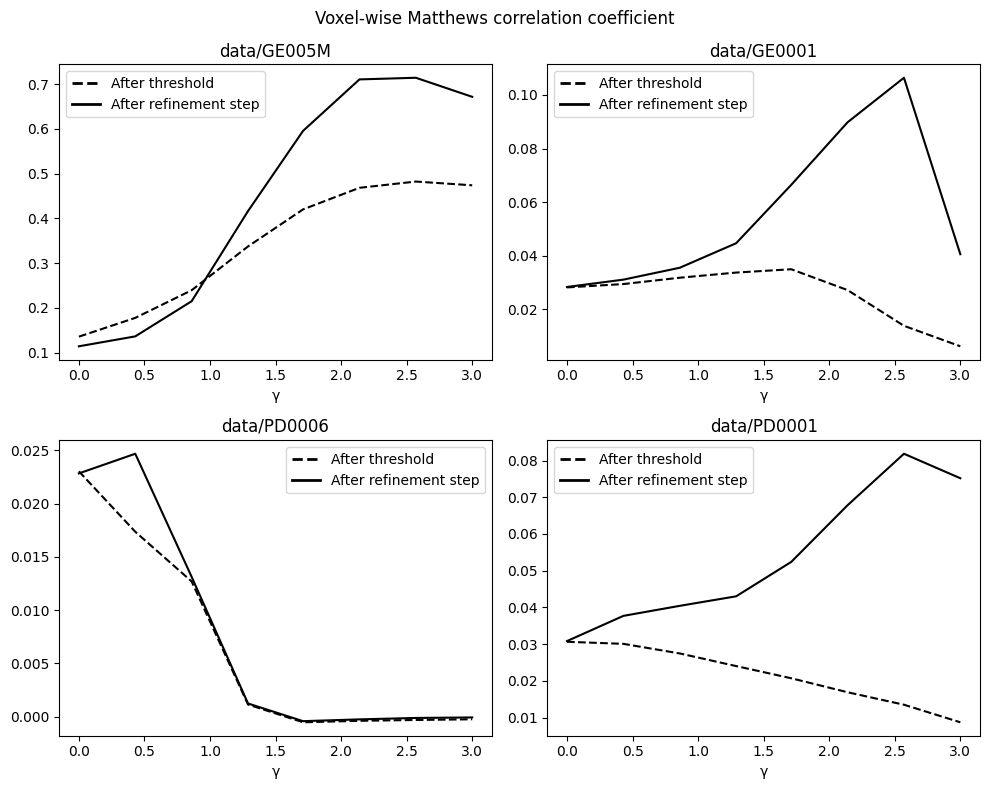

In [12]:
from matplotlib.lines import Line2D

processing_steps = [
    "after threshold",
    "after refinement step"
]

roots = paths_df.index
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

for i, root in enumerate(roots):

    rel_root = os.path.relpath(root, "data")
    anal_path = os.path.join("analysis", rel_root)
    
    results_thr = pd.read_pickle(os.path.join(anal_path, "evaluation metrics after threshold.pkl"))
    results_ref = pd.read_pickle(os.path.join(anal_path, "evaluation metrics after refinement step.pkl"))

    gammas = np.unique(results_thr.index)

    ax = axes[i//2, i%2]

    ax.plot(gammas, results_thr["vw-MCC"], color="black", linestyle="--")        
    ax.plot(gammas, results_ref["vw-MCC"], color="black", linestyle="-")

    ax.legend(handles= [
        Line2D([0], [0], color="black", lw=2, linestyle="--", label="After threshold"),
        Line2D([0], [0], color="black", lw=2, linestyle="-", label="After refinement step"),
    ])
    
    ax.set_xlabel("γ")
    ax.set_title(root)
    
    
plt.suptitle("Voxel-wise Matthews correlation coefficient")
plt.tight_layout()


    



Class imbalance????

In [ ]:
roots = paths_df.index

for i, root in enumerate(roots):
    
    gt = sitk.ReadImage(paths_df[gt_file][i])
    gt = sitk.Cast(gt, sitk.sitkUInt8)
    gt_arr = get_array_from_image(gt)
    n_pos = (gt_arr > 0).sum()
    n_neg = (gt_arr == 0).sum()

    print(np.unique(gt_arr))
    print(f"Folder {root}: n_positive = {n_pos}, n_negative = {n_neg}, ratio = {n_pos/n_neg}")

/tmp/ipykernel_44923/3174728571.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gt = sitk.ReadImage(paths_df[gt_file][i])


[0 1]
Folder data/GE005M: n_positive = 16296, n_negative = 21020760, ratio = 0.0007752336261866841
[0 1]
Folder data/GE0001: n_positive = 1088, n_negative = 21035968, ratio = 5.172093815697e-05
[0 1]
Folder data/PD0006: n_positive = 70, n_negative = 1572794, ratio = 4.450678219779577e-05
[0 1]
Folder data/PD0001: n_positive = 385, n_negative = 1572479, ratio = 0.00024483633803694675


PROVE GENERALI

/tmp/ipykernel_2379/3661040393.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flair = sitk.ReadImage(paths_df[flair_file][i])
/tmp/ipykernel_2379/3661040393.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t1 = sitk.ReadImage(paths_df[t1_file][i])
/tmp/ipykernel_2379/3661040393.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  segm = sitk.ReadImage(paths_df[segm_file][i])
/tmp/ipykernel_2379/3661040393.py:34: FutureWarn

Computing weighted sum of FLAIR and gaussian-transformed T1 (alpha = 5, beta = 1)...


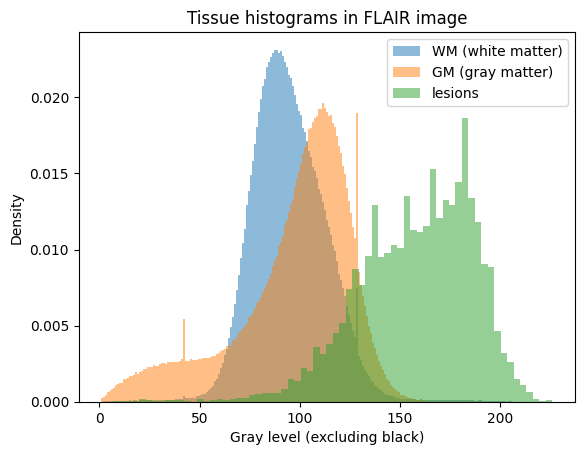

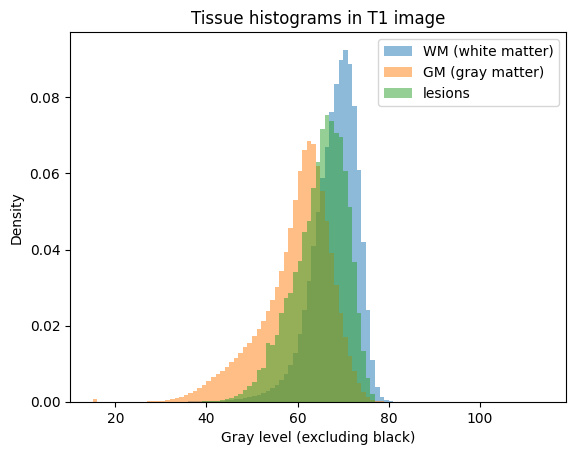

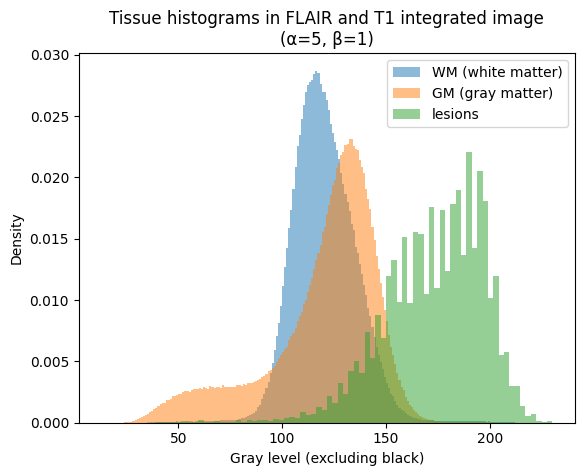

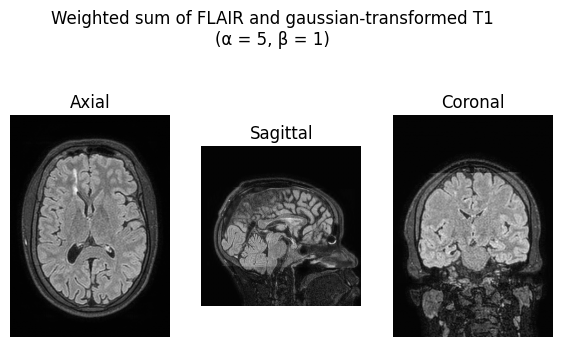

Applying threshold at gray level 164.5 (gamma = 2.0)...


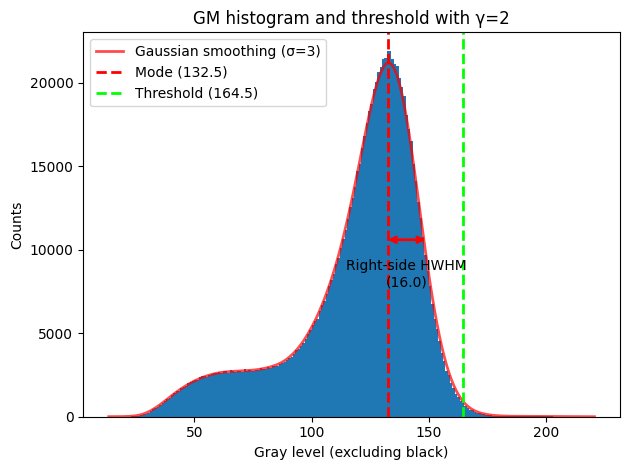

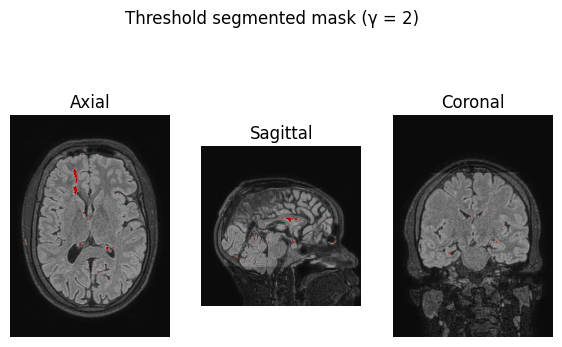

Number of connected components (lesions) in the image: 2722
Extending lesions (dilated with a nearly-isotropic kernel of radius 1 mm) with gray levels1 standard deviations away from mean...
Before lesion extension: 2722 connected components
After lesion extension: 2720 connected components
Applying diameter filter with a minimum diameter of 2 mm...
116 / 2720 lesions have minimum diameter >= 2 mm
Applying PVE filter inside the lesions...
1037 / 2720 lesions are predominantly composed of WM
974 / 2720 lesions are predominantly composed of GM
533 / 2720 lesions are predominantly composed of CSF
176 / 2720 lesions have null PVE effect for neither
WM, GM and CSF
Applying PVE filter around the lesions(dilated with a nearly-isotropic kernel of radius 1 mm)...
976 / 2720 lesions are predominantly surrounded by WM
813 / 2720 lesions are predominantly surrounded by GM
775 / 2720 lesions are predominantly surrounded by CSF
156 / 2720 lesions neighborhoods have null PVE effect
for neither WM, GM 

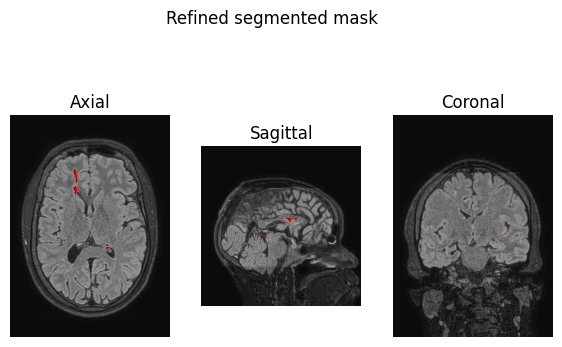

6284

In [4]:
from SilentInfarctionSegmentationFLAIR import threshold
from SilentInfarctionSegmentationFLAIR import histograms
from SilentInfarctionSegmentationFLAIR import utils
from SilentInfarctionSegmentationFLAIR import segmentation
from SilentInfarctionSegmentationFLAIR import refinement
from SilentInfarctionSegmentationFLAIR import refinement_step
from SilentInfarctionSegmentationFLAIR import flair_t1_sum
import importlib
importlib.reload(utils)
importlib.reload(segmentation)
importlib.reload(histograms)
importlib.reload(threshold)
importlib.reload(refinement)
importlib.reload(refinement_step)
importlib.reload(flair_t1_sum)
import gc
import matplotlib.pyplot as plt
sitk.ProcessObject.SetGlobalDefaultNumberOfThreads(1)

i=0

alpha=5
beta=1

flair = sitk.ReadImage(paths_df[flair_file][i])
flair = orient_image(flair, 'RAS')

t1 = sitk.ReadImage(paths_df[t1_file][i])
t1 = resample_to_reference(t1, flair)

segm = sitk.ReadImage(paths_df[segm_file][i])
segm = resample_to_reference(segm, flair)

gt = sitk.ReadImage(paths_df[gt_file][i])
gt = resample_to_reference(gt, flair)
gt = sitk.Cast(gt, sitk.sitkUInt8)
gm_mask = get_mask_from_segmentation(segm, gm_labels) 
wm_mask = get_mask_from_segmentation(segm, wm_labels)

pves = [sitk.ReadImage(paths_df[f][i])
        for f in [wm_pve_file, gm_pve_file, csf_pve_file]]
pves = [resample_to_reference(p, flair, sitk.sitkLinear)
        for p in pves]

image = flair_t1_sum.main(flair, t1, alpha=alpha, beta=beta,
                          gm_mask=gm_mask, wm_mask=wm_mask, gt=gt,
                          show=True, save_dir="results")

gc.collect() 

thr_mask = threshold.main(image, gm_mask, gamma=2,
                          show=True, save_dir="results")

gc.collect()

ref_mask = refinement_step.main(thr_mask, image, pves=pves, segm=segm, 
                                min_diameter=2, surround_dilation_radius=1, n_std=1, extend_dilation_radius=1,
                                min_points=3, show=True, save_dir="results")

gc.collect()
